In [1]:
import detectevent
from detectevent import DetectEvent
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

In [2]:
%matplotlib ipympl

In [ ]:
detector = detectevent.DetectEvent()

# Load data - adjust the file path and column names to match your CSV
data = detector.load_data("usgs_gage_data.csv",
                            time_column="datetime",
                            value_column="gage_height",
                            date_format="%Y-%m-%d %H:%M:%S")

# Detect events using a simple threshold approach
events = detector.detect_events_threshold(threshold=10.0,  # adjust threshold based on your data
                                        min_duration=30,   # minimum 30 minutes
                                        rise_rate=0.5)     # 0.5 feet per hour rise rate

# Alternatively, detect events using moving average approach
# events = detector.detect_events_moving_average(window_size=48,  # 48 data points
#                                              std_factor=2.5,   # 2.5 standard deviations
#                                              min_duration=30)  # minimum 30 minutes

# Visualize the results
detector.visualize_events(events, title="USGS Gage Height Events")

In [ ]:
data = pd.read_csv('usgs-data/01302020.csv')
time = data['datetime'].to_numpy()
height = data['00065'].to_numpy()
plt.clf()
# plt.plot(height[:-1], np.diff(height), color='purple', alpha= 0.5)
plt.plot(time, height)
plt.show()

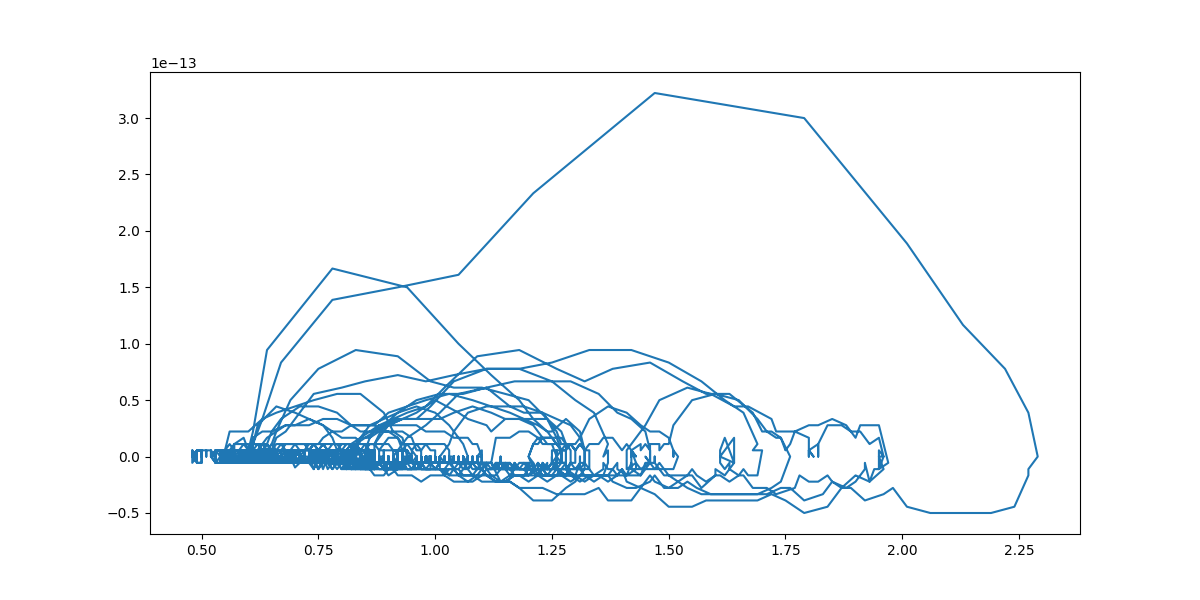

In [128]:
df = pd.read_csv('usgs-data/01302020_shorter2.csv')
df = df.rename(columns={'00065': 'height', 'datetime': 'time'})


df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S%z")

# method 1
df['time_num'] = df['time'].astype(np.int64)
df['dh_dt'] = np.gradient(df['height'], df['time_num'])

# method 2
# df['dh_dt'] = df['00065'].diff() / df['datetime'].diff().dt.total_seconds()

# plt.figure(figsize=(10, 6))
# sc = plt.scatter(
#     df['height'],
#     df['dh_dt'],
#     c=df['time_num'],  # Color by time
#     cmap='viridis',
#     s=5,
#     alpha=0.7
# )
# plt.colorbar(sc, label='Time')
# plt.xlabel('Height (m)')
# plt.ylabel('Rate of Change (dh/dt, m/s)')
# plt.title('Hysteresis Loops: Rate of Change vs. Height')
# # Add arrows to indicate loop direction
# plt.annotate(
#     'Flood Rise', xy=(5.0, 0.02), xytext=(1.5, 1e-13),
#     arrowprops=dict(arrowstyle="->", color='red')
# )
# plt.annotate(
#     'Flood Recession', xy=(5.5, -0.01), xytext=(6.0, -0.02),
#     arrowprops=dict(arrowstyle="->", color='blue')
# )
# plt.grid()



# flood_events = df[(df['dh_dt'] > 1e-7) & (df['00065'] > 0)]  # 0.05 ft/s and height >5ft


# Rolling 95th percentile of dh/dt (adaptive to seasonal changes)
# df['rise_threshold'] = df['dh_dt'].rolling(7).quantile(0.95)
# flood_events = df[df['dh_dt'] > df['rise_threshold']]

# Dynamic threshold (top 5% of positive rates)
# threshold = df['dh_dt'].quantile(0.90)
# floods = df[(df['dh_dt'] > threshold) & (df['00065'] > df['00065'].quantile(0.35))]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['height'], df['dh_dt'])
# plt.plot(df['datetime'], df['00065'], label='Height')
# plt.scatter(floods['datetime'], floods['00065'], color='red', label='Flood Events')
# plt.scatter(flood_events['datetime'], flood_events['00065'], color='red', label='Flood Events')
# plt.legend()

In [129]:
from scipy.integrate import simpson
df['height'] = df['height'].rolling(10, center=True).mean()
# Ensure time is datetime and calculate dh/dt
df['time'] = pd.to_datetime(df['time'])
df['dh_dt'] = np.gradient(df['height'])  # Assumes uniform time intervals

# Detect sign changes in derivative (peaks/troughs)
df['rising'] = df['dh_dt'] > 0
sign_changes = np.where(df['rising'].diff().fillna(False))[0]

# Group into events (rising + falling phases)
events = []
for i in range(0, len(sign_changes)-1, 2):
    start_idx = sign_changes[i]
    end_idx = sign_changes[i+1] if i+1 < len(sign_changes) else len(df)-1

    events.append({
        'start_time': df.iloc[start_idx]['time'],
        'end_time': df.iloc[end_idx]['time'],
        'peak_time': df.iloc[start_idx:end_idx+1]['height'].idxmax(),
        'max_height': df.iloc[start_idx:end_idx+1]['height'].max()
    })

events_df = pd.DataFrame(events)

/var/folders/pq/w466krps4015y7cfwg_sl2_40000gn/T/ipykernel_5169/2269662344.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sign_changes = np.where(df['rising'].diff().fillna(False))[0]


In [130]:
min_duration = pd.Timedelta('2h')  # 1 hour minimum
events_df = events_df[events_df['end_time'] - events_df['start_time'] >= min_duration]

In [131]:
events_df

,start_time,end_time,peak_time,max_height
1,2007-10-01 14:30:00+00:00,2007-10-01 18:30:00+00:00,53,0.490
2,2007-10-02 16:15:00+00:00,2007-10-02 19:00:00+00:00,151,0.500
3,2007-10-04 20:00:00+00:00,2007-10-04 22:00:00+00:00,355,0.496
6,2007-10-07 13:00:00+00:00,2007-10-07 18:15:00+00:00,628,0.528
12,2007-10-08 22:30:00+00:00,2007-10-09 01:15:00+00:00,752,0.540
...,...,...,...,...
137,2008-01-11 18:00:00+00:00,2008-01-11 21:45:00+00:00,9842,1.709
138,2008-01-14 01:30:00+00:00,2008-01-14 08:30:00+00:00,10077,1.094
139,2008-01-18 01:30:00+00:00,2008-01-18 15:15:00+00:00,10488,1.312
144,2008-01-21 22:30:00+00:00,2008-01-22 01:15:00+00:00,10816,0.800


In [132]:
import pandas as pd

def merge_close_events(events_df, max_gap='1h'):
    if len(events_df) == 0:
        return events_df

    # Convert max_gap to Timedelta if it's a string
    max_gap = pd.Timedelta(max_gap)

    # Sort by start time
    events_df = events_df.sort_values('start_time').reset_index(drop=True)

    merged_events = []
    current_event = events_df.iloc[0].copy()  # Initialize with the first event

    for _, next_event in events_df.iloc[1:].iterrows():
        gap = next_event['start_time'] - current_event['end_time']

        # If gap <= max_gap, merge into current_event
        if gap <= max_gap:
            current_event['end_time'] = next_event['end_time']
            current_event['max_height'] = max(current_event['max_height'], next_event['max_height'])
            # Update peak_time to the time of the higher peak
            if next_event['max_height'] > current_event['max_height']:
                current_event['peak_time'] = next_event['peak_time']
        else:
            merged_events.append(current_event)
            current_event = next_event.copy()

    # Add the last event
    merged_events.append(current_event)

    return pd.DataFrame(merged_events)

# Example usage
events_df = merge_close_events(events_df, max_gap='5h')

In [133]:
from scipy.integrate import simpson

def calculate_loop_area(event_row):
    """Calculate hysteresis loop area for a single event."""
    # Extract event data
    mask = (df['time'] >= event_row['start_time']) & (df['time'] <= event_row['end_time'])
    event_data = df.loc[mask]

    # Split into rising/falling phases
    rising = event_data[event_data['dh_dt'] > 0]
    falling = event_data[event_data['dh_dt'] < 0]

    # Check minimum points requirement (at least 3 points for simpson)
    if len(rising) < 3 or len(falling) < 3:
        return 0.0  # Return 0 for invalid segments

    # Sort by height for proper integration
    rising = rising.sort_values('height')
    falling = falling.sort_values('height')

    try:
        # Calculate absolute loop area
        area = abs(
            simpson(rising['dh_dt'].values, rising['height'].values) -
            simpson(falling['dh_dt'].values, falling['height'].values)
        )
        return area
    except:
        return 0.0

# Apply with error handling
events_df['loop_area'] = events_df.apply(calculate_loop_area, axis=1)

# Filter events (keep top 50% by area)
min_area = events_df['loop_area'].quantile(0.000001)
events_df = events_df[events_df['loop_area'] > min_area].copy()

In [109]:
events_df = events_df[events_df['valid_loop']]
events_df

,start_time,end_time,peak_time,max_height,loop_area,valid_loop
6,2007-10-09 23:15:00+00:00,2007-10-10 10:15:00+00:00,864,1.276,0.002969,True
10,2007-10-19 16:30:00+00:00,2007-10-20 14:30:00+00:00,1798,1.047,0.005133,True
17,2007-10-26 20:30:00+00:00,2007-10-27 18:15:00+00:00,2480,1.947,0.049475,True
21,2007-11-06 06:15:00+00:00,2007-11-06 20:00:00+00:00,3487,0.991,0.000147,True
23,2007-11-09 19:00:00+00:00,2007-11-10 16:00:00+00:00,3800,0.752,0.000031,True
28,2007-11-20 15:45:00+00:00,2007-11-21 07:45:00+00:00,4856,0.680,0.000175,True
36,2007-12-02 21:15:00+00:00,2007-12-03 14:15:00+00:00,6015,1.283,0.000593,True
46,2007-12-19 19:30:00+00:00,2007-12-20 12:15:00+00:00,7662,0.777,0.000054,True
55,2007-12-31 00:15:00+00:00,2007-12-31 11:15:00+00:00,8723,1.315,0.006878,True
57,2008-01-01 14:45:00+00:00,2008-01-02 00:15:00+00:00,8874,1.267,0.000587,True


In [106]:
def calculate_loop_area(event_row):
    """Robust loop area calculation with detailed edge-case handling."""
    mask = (df['time'] >= event_row['start_time']) & (df['time'] <= event_row['end_time'])
    event_data = df.loc[mask]

    # Split into rising/falling phases
    rising = event_data[event_data['dh_dt'] > 0].sort_values('height')
    falling = event_data[event_data['dh_dt'] < 0].sort_values('height')

    # Skip if insufficient data (but keep event metadata)
    if len(rising) < 2 or len(falling) < 2:
        return {
            'loop_area': 0,
            'valid_loop': False  # Flag for manual inspection
        }

    # Interpolate to align rising/falling curves at common heights
    min_h = max(rising['height'].min(), falling['height'].min())
    max_h = min(rising['height'].max(), falling['height'].max())
    h_range = np.linspace(min_h, max_h, 100)

    try:
        # Interpolate both phases to common height values
        rising_interp = np.interp(h_range, rising['height'], rising['dh_dt'])
        falling_interp = np.interp(h_range, falling['height'], falling['dh_dt'])

        # Calculate absolute loop area
        area = simpson(rising_interp - falling_interp, h_range)
        return {
            'loop_area': abs(area),
            'valid_loop': True
        }
    except:
        return {
            'loop_area': 0,
            'valid_loop': False
        }

# Apply and unpack results
loop_data = events_df.apply(calculate_loop_area, axis=1, result_type='expand')
events_df = pd.concat([events_df, loop_data], axis=1)

# Filter strategy (keep events with valid loops OR those that failed but had duration)
min_duration = pd.Timedelta('1h')
events_df = events_df[
    (events_df['valid_loop']) |
    ((events_df['end_time'] - events_df['start_time'] >= min_duration) &
     (events_df['loop_area'] == 0))
].copy()

/var/folders/pq/w466krps4015y7cfwg_sl2_40000gn/T/ipykernel_5169/2599224200.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  min_duration = pd.Timedelta('1H')


In [29]:
def dynamic_merge(events_df, base_gap='1H', height_factor=0.1):
    events_df = events_df.sort_values('start_time')
    merged_events = []
    current_event = events_df.iloc[0].copy()

    for _, next_event in events_df.iloc[1:].iterrows():
        # Scale gap tolerance with event height (larger events = wider merge window)
        dynamic_gap = pd.Timedelta(base_gap) * (1 + height_factor * current_event['max_height'])
        gap = next_event['start_time'] - current_event['end_time']

        if gap <= dynamic_gap:
            current_event['end_time'] = next_event['end_time']
            current_event['max_height'] = max(current_event['max_height'], next_event['max_height'])
        else:
            merged_events.append(current_event)
            current_event = next_event.copy()

    merged_events.append(current_event)
    return pd.DataFrame(merged_events)

events_df = dynamic_merge(events_df, base_gap='5h')

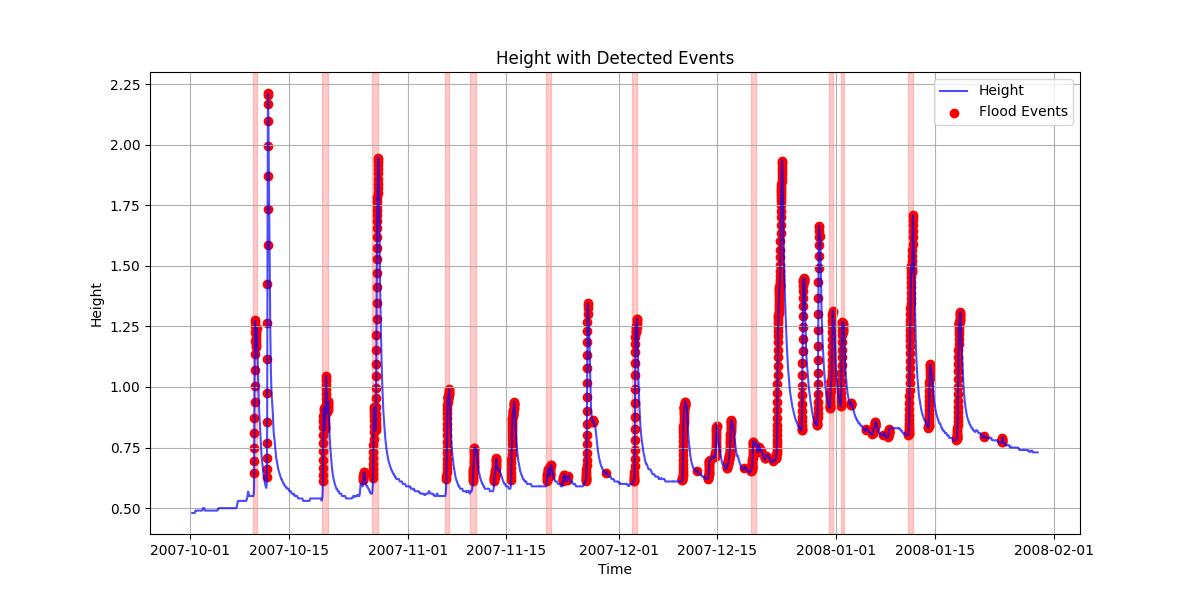

In [134]:
from scipy.signal import savgol_filter
df['dh_dt_smooth'] = savgol_filter(df['dh_dt'], window_length=11, polyorder=2)

plt.figure(figsize=(12, 6))

# Plot raw data
plt.plot(df['time'], df['height'], 'b-', label='Height', alpha=0.7)
# plt.plot(df['time'], df['height_smooth'], 'k-', label='Height', alpha=0.7)

# Highlight events
for _, event in events_df.iterrows():
    plt.axvspan(event['start_time'], event['end_time'],
               color='red', alpha=0.2, label='Event' if _ == 0 else "")
    # plt.scatter(event['peak_time'], event['max_height'],
    #            color='black', s=50, zorder=5)




# Rolling 95th percentile of dh/dt (adaptive to seasonal changes)
# df['rise_threshold'] = df['dh_dt'].rolling(7).quantile(0.95)
# flood_events = df[df['dh_dt'] > df['rise_threshold']]

# Dynamic threshold (top 5% of positive rates)
threshold = df['dh_dt'].quantile(0.90)
floods = df[(df['dh_dt'] > threshold) & (df['height'] > df['height'].quantile(0.35))]

# plt.plot(df['time'], df['height'], label='Height')
plt.scatter(floods['time'], floods['height'], color='red', label='Flood Events')
# plt.scatter(flood_events['time'], flood_events['height'], color='red', label='Flood Events')


plt.xlabel('Time')
plt.ylabel('Height')
plt.title('Height with Detected Events')
plt.legend()
plt.grid()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), dpi=100)

# 1. Time series plot
ax1.plot(df['datetime'], df['00065'], 'steelblue', label='Height')
for _, event in events_df.iterrows():
    color = 'red' if event['direction'] == 'clockwise' else 'green'
    ax1.axvspan(event['start_time'], event['end_time'], color=color, alpha=0.2)
    ax1.scatter(event['peak_time'], event['max_height'], color=color, s=50)
ax1.set_title('Height vs. Time\n(Red=Flood, Green=Release)')

# 2. Hysteresis plot with event highlights
sc = ax2.scatter(df['00065'], df['dh_dt'], c=df['datetime'].astype(np.int64), cmap='viridis', s=5)
for _, event in events_df.iterrows():
    mask = (df['datetime'] >= event['start_time']) & (df['datetime'] <= event['end_time'])
    ax2.scatter(df.loc[mask, '00065'], df.loc[mask, 'dh_dt'],
                color='red' if event['direction'] == 'clockwise' else 'green', s=15)
ax2.set_title('Hysteresis Loop with Events')

plt.colorbar(sc, ax=ax2, label='Time')
plt.tight_layout()

In [ ]:
rising = df[df['dh_dt'] > 0]    # Water level increasing
falling = df[df['dh_dt'] < 0]   # Water level decreasing

min_h, max_h = df['00065'].min(), df['00065'].max()
h_bins = np.linspace(min_h, max_h, 20)

for i in range(len(h_bins) - 1):
    h_low, h_high = h_bins[i], h_bins[i + 1]
    rising_segment = rising[(rising['00065'] >= h_low) & (rising['00065'] <= h_high)]
    falling_segment = falling[(falling['00065'] >= h_low) & (falling['00065'] <= h_high)]

    if len(rising_segment) > 10 and len(falling_segment) > 10:  # Minimum points
        print(f"Possible loop between {h_low:.2f}m and {h_high:.2f}m")

In [ ]:
from scipy.integrate import simpson

# Example: Integrate dh/dt over height for a segment
loop_area = simpson(rising_segment['dh_dt'], rising_segment['00065']) #- \
            # simpson(falling_segment['dh_dt'], falling_segment['00065'])
print(f"Loop area: {loop_area:.4f} (m²/s)")

In [ ]:
2112+8363+1078

In [ ]:
df.shape

In [ ]:
# data = pd.read_csv('usgs-data/01302020_shorter2.csv')
# time = data['datetime'].to_numpy()
# height = data['00065'].to_numpy()
# plt.clf()
# plt.plot(height[:-1], np.diff(height), color='purple', alpha= 0.5)
# plt.show()

In [ ]:
%matplotlib inline
plt.clf()
plt.plot(np.diff(height))
plt.show()

In [ ]:
# Get list of CSV files in the usgs-data directory
csv_files = glob.glob('usgs-data/*.csv')

# Loop through each CSV file
for csv_file in csv_files:
    # Read the CSV file
    data = pd.read_csv(csv_file)

    # Extract time and height data
    time = data['datetime'].to_numpy()
    height = data['00065'].to_numpy()

    # Create new figure for each file
    plt.figure()

    # Plot the data
    plt.plot(height[:-1], np.diff(height), color='purple', alpha=0.5)
    plt.title(f'Height vs Height Difference for {os.path.basename(csv_file)}')
    plt.xlabel('Height')
    plt.ylabel('Height Difference')
    plt.show()